In [1]:
projectdir = "C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia"
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, Interact, LsqFit, CSV, Blink, Pipe, ProgressMeter
pyplot()

include("Turnover.jl")
include("test.jl")
using .Turnover

using TumorGrowth: DataFrame, clones_by_mutations, nonspatial, nonspatial!, data_import

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1347013881945351739\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13218472331567489813\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1347013881945351739\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

  Activating environment at `C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


Test Summary:             | Pass  Total
Applying turnover methods |    7      7


In [2]:
measured = include("turnover_data/estranged_turnover_v2.jl")
expect = include("turnover_data/expected_estranged_turnover_v2.jl")
measured[1]

Dict{Symbol, Any} with 8 entries:
  :std      => [0.04838, 0.06156, 0.07108, 0.07468, 0.07683, 0.0815, 0.08195, 0…
  :b        => 1.0
  :N        => 2000
  :Ncutoff  => 200
  :μ        => 0.4
  :reps     => 100
  :turnover => [0.06155, 0.09778, 0.12215, 0.1403, 0.16959, 0.21673, 0.24016, 0…
  :d        => [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.5…

#### Expected / Measured estranged Turnover vs mutation rate

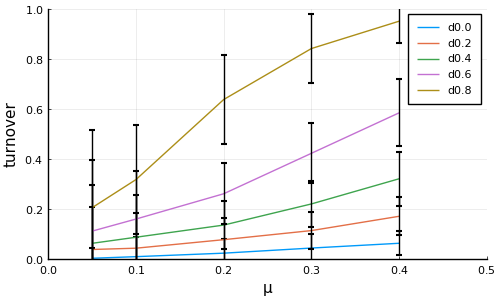

In [3]:
let data = measured
    ds = data[1][:d]
    mus = getindex.(data, :μ)
    t = [ [ res[:turnover][i] for res in data] for i=1:length(ds)]
    stdev = [ [ res[:std][i] for res in data] for i=1:length(ds)]

    p=plot(xlim=(0., 0.5), ylim=(0,1), xlab=:μ, ylab=:turnover, size=(500,300))
    for i=1:4:length(ds)
        plot!(mus, t[i], yerror=stdev[i], lab="d$(ds[i])")
    end
    p
end

#### Fitting death rate for Expected / Measured estranged Turnover

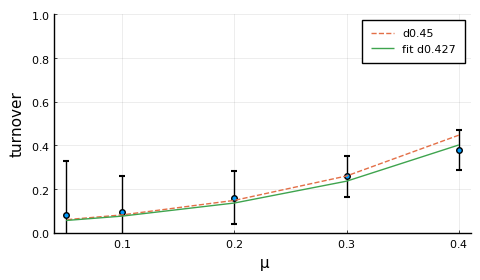

In [6]:
let data = measured
    ds = data[1][:d]
    mus = getindex.(data, :μ)
    t = [ [ res[:turnover][i] for res in data] for i=1:length(ds)]
    stdev = [ [ res[:std][i] for res in data] for i=1:length(ds)]

    dslider = slider(ds)
    function model(mus, p)
        d = p[1]
        map( mus ) do mu
            min(1., W_estranged(d; b=1., μ=mu, T=log(200)/(1-d)))
        end
    end

#     ui = @manipulate for d in dslider
    function plot_d(d)
        i = dslider[:index].val
        fit = curve_fit(model, mus, t[i], [0.5])

        plot(ylim=(0,1), xlab=" μ", size=(500,300), ylab=:turnover, margin=5Plots.mm)
        scatter!(mus, t[i], yerror=stdev[i], lab="")
        plot!(mus, model(mus, d), lab="d$d", style=:dash)
        d_fit = round(first(fit.param), digits=3)
        plot!(mus, model(mus, fit.param), lab="fit d$d_fit")
    end
    interactive_plot = map(plot_d, dslider)
    ui = vbox(dslider, interactive_plot)
    w = Window()
    body!(w, ui)
end
;

#### Fitting `d` and `μ` simultaneously for Expected / Measured estranged Turnover

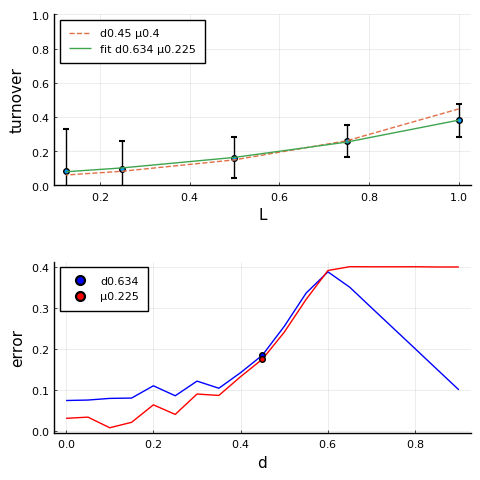

In [12]:
let data = measured
    ds = data[1][:d]
    mus = getindex.(data, :μ)
    t = [ [ res[:turnover][i] for res in data] for i=1:length(ds)]
    stdev = [ [ res[:std][i] for res in data] for i=1:length(ds)]

    dslider = slider(ds, label="b")

    function model(Ls, p)
        d, mu = p
        (d<0. || d>=1. || mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(200)/(1-d)))
        end
    end

    mup = first(mus)
    Ls = mus./mup

    fits = map( tp-> curve_fit(model, Ls, tp, [0.5, 0.5]), t)
    d_err = abs.(getindex.(getfield.(fits, :param),1) .- ds)
    mu_err = abs.(getindex.(getfield.(fits, :param),2) .- mup)

    ui = @manipulate for d in dslider
        i = dslider[:index].val
        fit = fits[i]

        p = plot(layout=(2,1), size=(500,500), legend=:topleft, margin=5Plots.mm)
        plot!(p[1], xlab="L", ylab=:turnover, ylims=(0,1) )
        scatter!(p[1], Ls, t[i], yerror=stdev[i], lab="")
        plot!(p[1], Ls, model(Ls, [ds[i], first(mus)]), lab= "d$(ds[i]) μ$mup", style=:dash)
        d_fit, mu_fit = round.(fit.param, digits=3)
        plot!(p[1], Ls, model(Ls, fit.param), lab="fit d$d_fit μ$mu_fit")

        plot!(p[2], xlab="d", ylab=:error )
        plot!(p[2], ds, d_err, lab="", c=:blue)
        plot!(p[2], ds, mu_err, lab="", c=:red)
        scatter!(p[2], [ds[i]], [d_err[i]], lab="d$d_fit", c=:blue)
        scatter!(p[2], [ds[i]], [mu_err[i]], lab="μ$mu_fit", c=:red)
        end;
    w = Window()
    body!(w, ui);
end
;

## Inference for single tumor

In [14]:
### run
N, Nthresh = 200000, 2000
b, d, mu = simparams = (b=1., d=0.3, μ=0.3)
out = neutral_growth(Nthresh; simparams..., return_obs=false)
cutoff = length(out[:tumor])
neutral_growth!(out[:tumor], N; simparams...)


orphaned_tumor = out[:tumor] |> DataFrame |> df -> remove_mutations(df, 1:cutoff-1)

estranged_tumor = out[:tumor][1:cutoff] |> DataFrame

(orphaned_tumor, estranged_tumor) .|> nrow |> println

(873, 873)


In [15]:
### save
# CSV.write("turnover_data/simulated_tumors/tumor_N$(N)_b$(b)_d$(d)_μ$(mu)_Nthresh$(Nthresh)_M$cutoff.csv", DataFrame(out[:tumor]))

"turnover_data/simulated_tumors/tumor_N200000_b1.0_d0.3_μ0.3_Nthresh2000_M873.csv"

In [2]:
# ### load
b, d, mu, N, Nthresh = (b=1., d=0.3, μ=0.3, N=200000, Nthresh=2000)
M = 873
tumor = data_import("turnover_data/simulated_tumors/tumor_N$(N)_b$(b)_d$(d)_μ$(mu)_Nthresh$(Nthresh)_M$(M).csv", delim=",");

orphaned_tumor = tumor |> DataFrame |> df -> remove_mutations(df, 1:M-1)

estranged_tumor = tumor[1:M,:] |> DataFrame

(orphaned_tumor, estranged_tumor) .|> nrow |> println

(873, 873)


In [3]:
Ls = 0.1:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [filter(h->!iszero(h.n), reduced_μ(estranged_tumor, L) ) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
        end )
    end

### theory + low noise
# t = [ W_estranged(d; b=b, μ=L*mu, T=log(Nthresh)/(b-d) ) .+ 0.1*randn(50) for L in Ls]
;

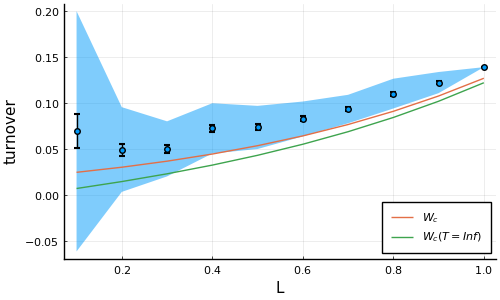

In [4]:
let t = estranged_turnover
    scatter(Ls, mean.(estranged_turnover), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, size=(500, 300), legend=:bottomright)
    plot!(Ls, L -> W_estranged(d; b=b, μ=L*mu, T=log(Nthresh)/(b-d) ), lab=L"W_c" )
    plot!(Ls, L -> W_estranged(d; b=b, μ=L*mu, T=Inf ), lab=L"W_c (T=Inf)" )
end

#### Simultaneous fit of `d` and `μ` for mean estranged turnover curve

[d,μ] : [0.3, 0.3]
fit : [0.5855881621290598, 0.127168344656086]


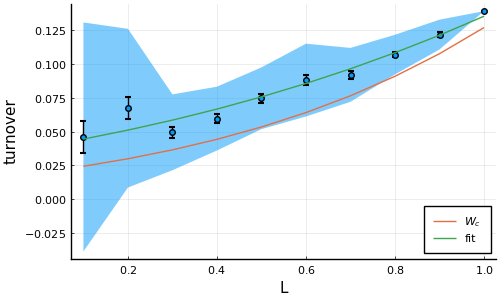

In [85]:
let t = estranged_turnover
    global b, Nthresh
    
    function model(Ls, p)
        d, mu = p
        (d<0. || d>=1. || mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=b, μ=mu*L, T=log(Nthresh)/(b-d)))
        end
    end

    fit = curve_fit(model, Ls, mean.(t), [0.5, 0.5])
    d_err, mu_err = abs.(fit.param .- (d, mu) )
    
    p = scatter(Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, size=(500, 300), legend=:bottomright)
    plot!(Ls, model(Ls, [d, mu]), lab=L"W_c" )
    plot!(Ls, model(Ls, fit.param), lab="fit" )
    println("[d,μ] : ", [d,mu])
    println("fit : ",fit.param)
    p
end

#### Simultaneous fit of `d` and `μ` for sampled estranged turnover curves

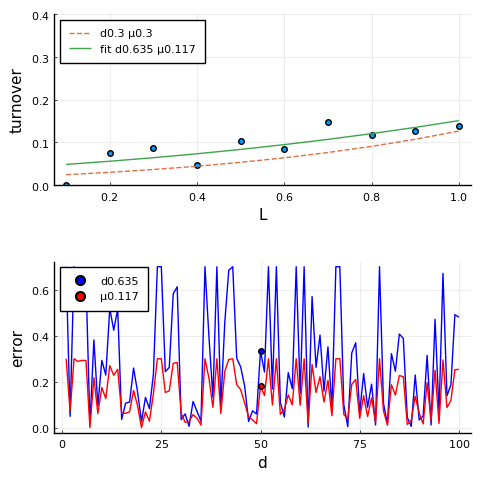

In [65]:
let t = estranged_turnover
    global b, Nthresh
    
    function model(Ls, p)
        d, mu = p
        (d<0. || d>=1. || mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=b, μ=mu*L, T=log(Nthresh)/(b-d)))
        end
    end

    tvecs = [ rand.(t) for _=1:100 ]

    fits = map( tp-> curve_fit(model, Ls, tp, [0.5, 0.5]), tvecs)
    d_fits, mu_fits = getindex.(getfield.(fits, :param),1), getindex.(getfield.(fits, :param),2)
    d_err, mu_err = abs.(d_fits .- d), abs.(mu_fits .- mu)

    ui = @manipulate for i in slider(1:length(fits))
        fit = fits[i]

        p = plot(layout=(2,1), size=(500,500), legend=:topleft, margin=5Plots.mm)
        plot!(p[1], xlab="L", ylab=:turnover, ylims=(0, maximum(maximum.(t))) )
        scatter!(p[1], Ls, tvecs[i], lab="")
        plot!(p[1], Ls, model(Ls, [d, mu]), lab= "d$d μ$mu", style=:dash)
        d_fit, mu_fit = round.(fit.param, digits=3)
        plot!(p[1], Ls, model(Ls, fit.param), lab="fit d$d_fit μ$mu_fit")

        plot!(p[2], xlab="d", ylab=:error )
        plot!(p[2], 1:length(fits), d_err, lab="", c=:blue)
        plot!(p[2], 1:length(fits), mu_err, lab="", c=:red)
        scatter!(p[2], [i], [d_err[i]], lab="d$d_fit", c=:blue)
        scatter!(p[2], [i], [mu_err[i]], lab="μ$mu_fit", c=:red)
    end
    body!(Window(), ui)
end;

### Infering `d` from orphaned turnover and `μ` from estranged turnover

In [5]:
using Distributions, NLsolve, Roots
z = nlsolve(x->cdf.(Normal(), x) .- 0.975, [1.]).zero[1]

1.9599639704623484

#### Get `q` given orphaned turnover of tumor

 d : 0.3
0.415999352750544


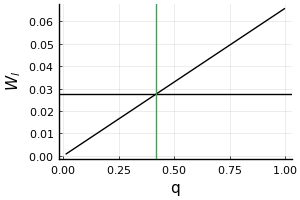

In [10]:
let W_l = orphaned_red_treeless(filter(h->!iszero(h.n), orphaned_tumor)) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

    qval = 2*log(Nthresh)*W_l
    println(" d : ", d)
    println(qval)
    plot(0.01:0.01:1., q->W_orphaned(q;N=Nthresh), legend=:none, size=(300,200), c=:black, xlab=:q, ylab=L"W_l")
    hline!([W_l], c=:black); vline!([qval], lab="")
end

#### orphaned turnover for varying effective `μ`

W : 0.027787541061773502 ± 0.0010459701268352134
q : 0.42242077840212167 ± 0.015900633819338643


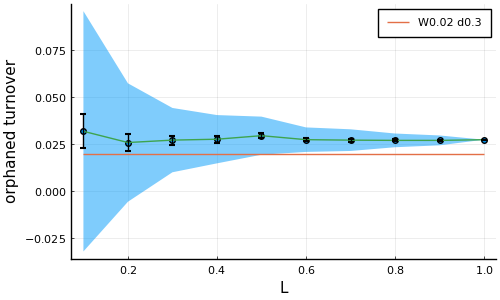

In [93]:
let orphaned_tumors = map( Ls ) do L
        [filter(h->!iszero(h.n), reduced_μ(orphaned_tumor, L) ) for _=1:reps]
    end

    t = map(orphaned_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = orphaned_red_treeless(tumor)
            sum(res.isorphaned)/sum(res.isgreen)
        end )
    end

    qvals = map(t) do Ws
            2*log(Nthresh).*Ws
        end

    global d, b, Nthresh
    p = scatter(Ls, mean.(t), ribbon=std.(t), lab="", xlab=:L, ylab="orphaned turnover", size=(500,300))
    plot!(Ls, L-> W_orphaned(d/b; N=Nthresh),
        lab="W$(round(W_orphaned(d/b; N=Nthresh),digits=3)) d$d" )
    plot!(Ls, mean.(t), yerror=std.(t)./sqrt.(length.(t)), lab="" )

    println("W : ", mean(mean.(t)), " ± ", 1.96*std(mean.(t))/sqrt(length(t)) )
    println("q : ", mean(mean.(qvals)), " ± ", 1.96*std(mean.(qvals))/sqrt(length(t)) )
    p
end

#### Given `d` compute `μ` from estranged turnover of tumor

In [7]:
function bisection(f, interval, iter; precision=1e-9)
    xlow, xup = interval
    sign(f(xlow)) == sign(f(xup)) && error("no zero in interval $interval")
    any((isnan.(f.(interval)))) && error("f not defined on interval $interval")
    for i=1:iter
        xm = (xlow+xup)/2
        abs(f(xm)) < precision && return (xm, i)
        if sign(f(xm)) != sign(f(xlow))
            xup = xm
        else
            xlow = xm
        end
    end
    println(xup)
    error("no convergence within $iter steps")
end

bisection (generic function with 1 method)

μ : 0.3
0.23785720353745254


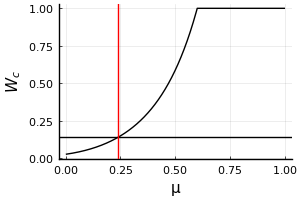

In [8]:
let d = 0.4
    global b, Nthresh, mu
    t = estranged_turnover
    
    W_c = estranged_treeless(filter(h->!iszero(h.n), estranged_tumor)) |> df -> sum(df.isestranged)/sum(df.isgreen)

#     mu_solve, n = bisection(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, [0.01,0.99], 100)
    mu_solve = fzero(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, 0.01, 1.)

    println("μ : ", mu)
    println(mu_solve)
    plot(0.:0.001:1., mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d))), size=(300,200),
        legend=:none, c=:black, xlab=:μ, ylab=L"W_c")
    hline!([W_c], c=:black); vline!([mu_solve], c=:red)
end

#### Given `d` fit `μ` for sampled estranged turnover curves

μ : 0.3
mean fit : 0.24504670385192384
averaged fits : 0.2452676323112066 ± 0.0005755193172730344


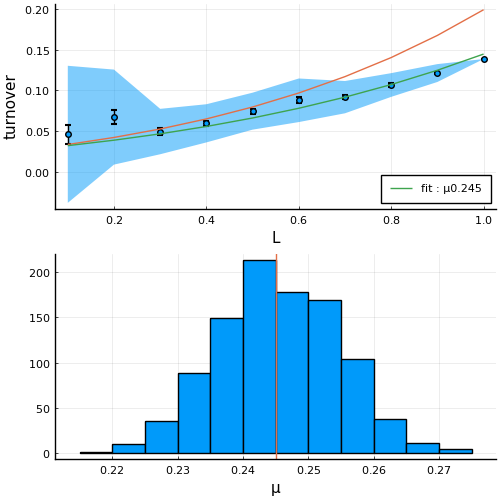

In [102]:
let d = 0.4
    t = estranged_turnover
    global b, Nthresh, mu
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=b, μ=mu*L, T=log(Nthresh)/(b-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [0.5])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright)
    plot!(Ls, model(Ls, [mu]), lab="" )
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [0.5]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("μ : ", mu)
    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(500,500))
end

# Statistics for different `d`, `μ`

In [4]:
function read_params(path)
    @pipe split(path, "/")[end] |> replace(_, ".csv"=>"") |> split(_, "_") |> 
    (   N = parse(Int,_[2][2:end]),
        b = parse(Float64, _[3][2:end]),
        d = parse(Float64, _[4][2:end]),
            mu = parse(Float64, _[5][3:end]),
        Nthresh = parse(Int, _[6][8:end]),
        M = parse(Int, _[7][2:end]),
            id = parse(Int, _[8][3:end])
        )
end

read_params (generic function with 1 method)

## fix μ and vary d

In [ ]:
let mu = 0.2
    @showprogress for d in 0.1:0.1:0.8
        for i = 1:10
            N, Nthresh = 100000, 2000
            b, d, mu = simparams = (b=1., d=d, μ=mu)
            out = neutral_growth(Nthresh; simparams..., return_obs=false, showprogress=false)
            cutoff = length(out[:tumor])
            neutral_growth!(out[:tumor], N;showprogress=false, simparams...)

            CSV.write("turnover_data/simulated_tumors/series_mu0.2/tumor_N$(N)_b$(b)_d$(d)_μ$(mu)_Nthresh$(Nthresh)_M$(cutoff)_id$(i).csv", DataFrame(out[:tumor]))
        end
    end
end   

In [5]:
ds = Float64[]
dfits = Float64[]
mufits = Float64[]

let mu = 0.2
    dir = "turnover_data/simulated_tumors/series_mu0.2/"
    paths = dir .* filter!(s -> occursin("tumor_",s),  readdir(dir))
    @showprogress for path in paths
        parameters = read_params(path)
        Nthresh, b, d = parameters.Nthresh, parameters.b, parameters.d
        
        tumor = data_import(path, delim=",")
        orphaned_tumor = tumor |> DataFrame |> df -> remove_mutations(df, 1:parameters.M-1)
        estranged_tumor = tumor[1:parameters.M,:] |> DataFrame
        
        # get d
        W_l = orphaned_red_treeless(filter(h->!iszero(h.n), orphaned_tumor)) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

        d_solve = min(1., 2*log(Nthresh)*W_l)
        
        # get mu
        W_c = estranged_treeless(filter(h->!iszero(h.n), estranged_tumor)) |> df -> sum(df.isestranged)/sum(df.isgreen)
        
        try
            mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, [0.01,0.99], 100)
#             mu_solve = fzero(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, 0.01, 0.99)
            
            push!(ds, d)
            push!(dfits, d_solve)
            push!(mufits, mu_solve)
        catch e
            println("d$d : d_solve$d_solve W_l $W_l W_c $W_c id$(parameters.id)")
        end
        
    end
end

Progress:  78%|████████████████████████████████         |  ETA: 0:01:15

d0.7 : d_solve1.0 W_l 0.07925925925925927 W_c 0.4117647058823528 id10


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:47

d0.7 : d_solve1.0 W_l 0.08387096774193549 W_c 0.5505050505050504 id2


Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:32

d0.8 : d_solve1.0 W_l 0.10784313725490197 W_c 0.7865168539325843 id1


Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:17

d0.8 : d_solve1.0 W_l 0.07216839291680588 W_c 0.6138613861386139 id2


Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:12

d0.8 : d_solve1.0 W_l 0.0798076923076923 W_c 0.7837837837837838 id7


Progress: 100%|█████████████████████████████████████████| Time: 0:08:13


d0.8 : d_solve1.0 W_l 0.11228406909788867 W_c 0.7956989247311828 id10


In [86]:
method, mu, ds, dfits, mufits = include(projectdir*"/Turnover/inference_results.jl")[1];

In [72]:
# let mu = 0.2
#     @showprogress for (d, i) in [(0.7,2), (0.7,10), (0.8,1), (0.8,2), (0.8,7), (0.8,10) ]
#         N, Nthresh = 100000, 2000
#         b, d, mu = simparams = (b=1., d=d, μ=mu)
#         out = neutral_growth(Nthresh; simparams..., return_obs=false, showprogress=false)
#         cutoff = length(out[:tumor])
#         neutral_growth!(out[:tumor], N;showprogress=false, simparams...)

#         CSV.write("turnover_data/simulated_tumors/series_mu$mu/tumor_N$(N)_b$(b)_d$(d)_μ$(mu)_Nthresh$(Nthresh)_M$(cutoff)_id$(i).csv", DataFrame(out[:tumor]))
#     end
# end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:34


In [87]:
bins = sort!(unique(ds))
dfits_binned = [ [dfits[findall(isequal(d), ds)]...] for d in bins]
mufits_binned = [ [mufits[findall(isequal(d), ds)]...] for d in bins]
length.(dfits_binned) |> println

[10, 10, 10, 10, 10, 10, 8, 6]


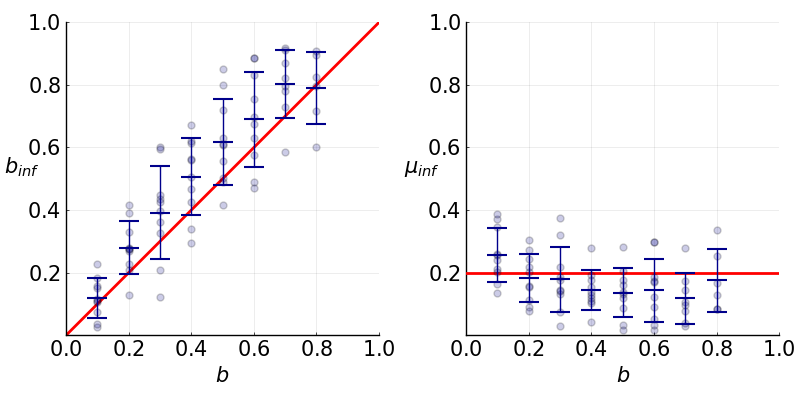

In [88]:
let mu = 0.2
    p = plot(layout=(1,2), legend=:none, yguidefontrotation=-90, size=(800,400),
             aspect_ratio=1, xaxis=(L"b", (0,1), 0:0.2:1), yaxis=((0,1),0.2:0.2:1), guidefontsize=15, tickfont=15)

    plot!(p[1], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[1], ds, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    scatter!(p[2], ds, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
end

In [10]:
# savefig("turnover_plots/inference_new/vary_d_solve.png")

In [41]:
ds = Float64[]
dfits = Vector{Union{Missing,Float64}}()
mufits = Vector{Union{Missing,Float64}}()

let mu = 0.2
    dir = "turnover_data/simulated_tumors/series_mu0.2/"
    paths = dir .* filter!(s -> occursin("tumor_",s),  readdir(dir))
    @showprogress for path in paths
        parameters = read_params(path)
        Nthresh, b, d = parameters.Nthresh, parameters.b, parameters.d
        
        tumor = data_import(path, delim=",")
        orphaned_tumor = tumor |> DataFrame |> df -> remove_mutations(df, 1:parameters.M-1)
        estranged_tumor = tumor[1:parameters.M,:] |> DataFrame
        
        
        # get d
        W_l = orphaned_red_treeless(filter(h->!iszero(h.n), orphaned_tumor)) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

        d_solve = min(1., 2*log(Nthresh)*W_l)
        
        # get mu
        
        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [filter(h->!iszero(h.n), reduced_μ(estranged_tumor, L) ) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    res = estranged_treeless(tumor)
                    sum(res.isestranged)/sum(res.isgreen)
                end )
            end
        
        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d; b=b, μ=mu*L, T=log(Nthresh)/(b-d)))
            end
        end
        
        fit = curve_fit(model, Ls, mean.(estranged_turnover), [0.5])
        mu_fit = fit.param[1]
        
        push!(ds, d)
        push!(dfits, d_solve==1.0 ? missing : d_solve)
        push!(mufits, mu_fit==0.5 ? missing : mu_fit)
        
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:13:22


In [82]:
method, mu, ds, dfits, mufits = include(projectdir*"/Turnover/inference_results.jl")[3];

In [83]:
bins = sort!(unique(ds))
dfits_binned = [ filter!(!ismissing, dfits[findall(isequal(d), ds)]) for d in bins]
mufits_binned = [ filter!(!ismissing, mufits[findall(isequal(d), ds)]) for d in bins]
length.(dfits_binned) |> println

[10, 10, 10, 10, 10, 10, 8, 6]


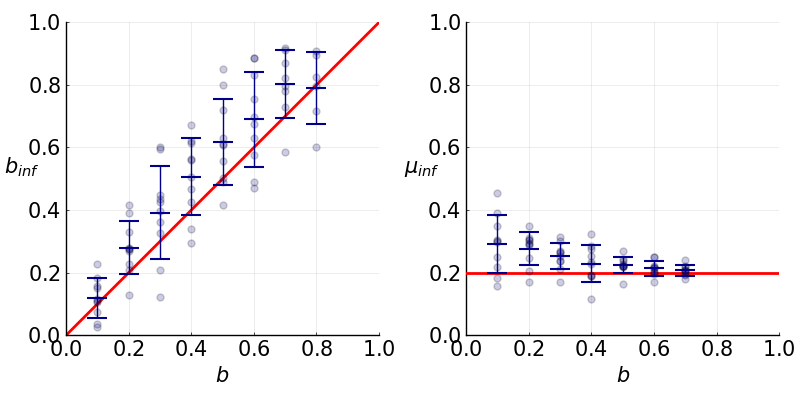

In [85]:
let mu = 0.2
    p = plot(layout=(1,2), legend=:none, yguidefontrotation=-90, size=(800,400),
             aspect_ratio=1, xaxis=(L"b", (0,1), 0:0.2:1), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15)

    plot!(p[1], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[1], ds, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    scatter!(p[2], ds, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

In [40]:
# savefig("turnover_plots/inference_new/vary_d_fit.pdf")

## fix d and vary μ

In [ ]:
let d = 0.4
    @showprogress for mu in 0.1:0.1:0.8
        for i = 1:10
            N, Nthresh = 100000, 2000
            b, d, mu = simparams = (b=1., d=d, μ=mu)
            out = neutral_growth(Nthresh; simparams..., return_obs=false, showprogress=false)
            cutoff = length(out[:tumor])
            neutral_growth!(out[:tumor], N;showprogress=false, simparams...)

            CSV.write("turnover_data/simulated_tumors/series_d0.4/tumor_N$(N)_b$(b)_d$(d)_μ$(mu)_Nthresh$(Nthresh)_M$(cutoff)_id$(i).csv", DataFrame(out[:tumor]))
        end
    end
end  

In [95]:
mus = Float64[]
dfits = Float64[]
mufits = Float64[]

let d = 0.4
    dir = "turnover_data/simulated_tumors/series_d0.4/"
    paths = dir .* filter!(s -> occursin("tumor_",s),  readdir(dir))
    @showprogress for path in paths
        parameters = read_params(path)
        Nthresh, b, mu = parameters.Nthresh, parameters.b, parameters.mu
        
        tumor = data_import(path, delim=",")
        orphaned_tumor = tumor |> DataFrame |> df -> remove_mutations(df, 1:parameters.M-1)
        estranged_tumor = tumor[1:parameters.M,:] |> DataFrame
        
        # get d
        W_l = orphaned_red_treeless(filter(h->!iszero(h.n), orphaned_tumor)) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

        d_solve = min(1., 2*log(Nthresh)*W_l)
        
        # get mu
        W_c = estranged_treeless(filter(h->!iszero(h.n), estranged_tumor)) |> df -> sum(df.isestranged)/sum(df.isgreen)
        
        try
            mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, [0.01,0.99], 100)
#             mu_solve = fzero(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, 0.01, 0.99)
            
            push!(mus, mu)
            push!(dfits, d_solve)
            push!(mufits, mu_solve)
        catch e
            println("μ$(mu) : d_solve$d_solve W_l $W_l W_c $W_c id$(parameters.id)")
        end
        
    end
end

In [79]:
method, mu, ds, dfits, mufits = include(projectdir*"/Turnover/inference_results.jl")[2];

In [131]:
# let d = 0.4
#     @showprogress for (mu, i) in [(0.1,5)]
#         N, Nthresh = 100000, 2000
#         b, d, mu = simparams = (b=1., d=d, μ=mu)
#         out = neutral_growth(Nthresh; simparams..., return_obs=false, showprogress=false)
#         cutoff = length(out[:tumor])
#         neutral_growth!(out[:tumor], N;showprogress=false, simparams...)

#         CSV.write("turnover_data/simulated_tumors/series_d$(d)/tumor_N$(N)_b$(b)_d$(d)_μ$(mu)_Nthresh$(Nthresh)_M$(cutoff)_id$(i).csv", DataFrame(out[:tumor]))
#     end
# end

In [80]:
bins = sort!(unique(mus))
dfits_binned = [ filter!(!ismissing, dfits[findall(isequal(mu), mus)]) for mu in bins]
mufits_binned = [ filter!(!ismissing, mufits[findall(isequal(mu), mus)]) for mu in bins]
length.(dfits_binned) |> println

[10, 10, 10, 10, 10, 10, 10, 10]


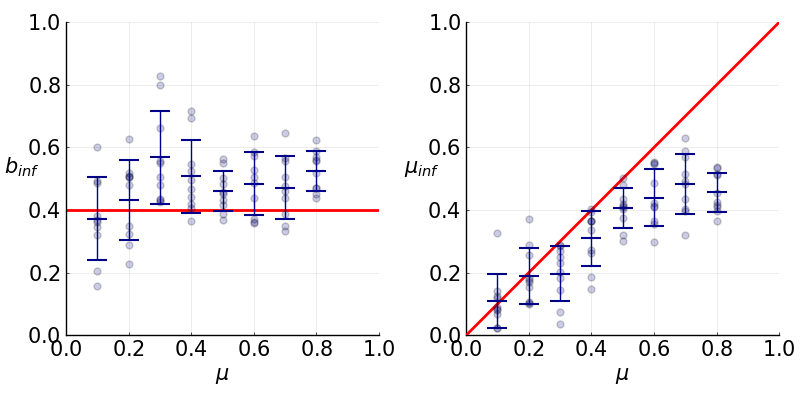

In [81]:
let d = 0.4
    p = plot(layout=(1,2), legend=:none, yguidefontrotation=-90, xlab=L"mu", size=(800,400),
             aspect_ratio=1, xaxis=(L"\mu", (0,1), 0:0.2:1), yaxis=((0,1),0:0.2:1), ticks=0:0.2:1, guidefontsize=15, tickfont=15)
    
    hline!(p[1], [d], c=:red, lw=2.)
    scatter!(p[1], mus, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    plot!(p[2], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[2], mus, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)

end

In [45]:
# savefig("turnover_plots/inference_new/vary_mu_solve.pdf")

In [89]:
mus = Float64[]
dfits = Float64[]
mufits = Float64[]

let d = 0.4
    dir = "turnover_data/simulated_tumors/series_d0.4/"
    paths = dir .* filter!(s -> occursin("tumor_",s),  readdir(dir))
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        Nthresh, b, mu = parameters.Nthresh, parameters.b, parameters.mu
        
        tumor = data_import(path, delim=",")
        orphaned_tumor = tumor |> DataFrame |> df -> remove_mutations(df, 1:parameters.M-1)
        estranged_tumor = tumor[1:parameters.M,:] |> DataFrame
        
        
        # get d
        W_l = orphaned_red_treeless(filter(h->!iszero(h.n), orphaned_tumor)) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

        d_solve = min(1., 2*log(Nthresh)*W_l)
        
        # get mu
        
        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [filter(h->!iszero(h.n), reduced_μ(estranged_tumor, L) ) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    res = estranged_treeless(tumor)
                    sum(res.isestranged)/sum(res.isgreen)
                end )
            end
        
        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d; b=b, μ=mu*L, T=log(Nthresh)/(b-d)))
            end
        end
        
        fit = curve_fit(model, Ls, mean.(estranged_turnover), [0.5])
        mu_fit = fit.param[1]
        
        push!(mus, mu)
        push!(dfits, d_solve)
        push!(mufits, mu_fit)
        
        next!(prog)        
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:28:20


In [92]:
bins = sort!(unique(mus))
dfits_binned = [ [dfits[findall(isequal(mu), mus)]...] for mu in bins]
mufits_binned = [ [mufits[findall(isequal(mu), mus)]...] for mu in bins]
length.(dfits_binned) |> println

[10, 10, 10, 10, 10, 10, 10, 10]


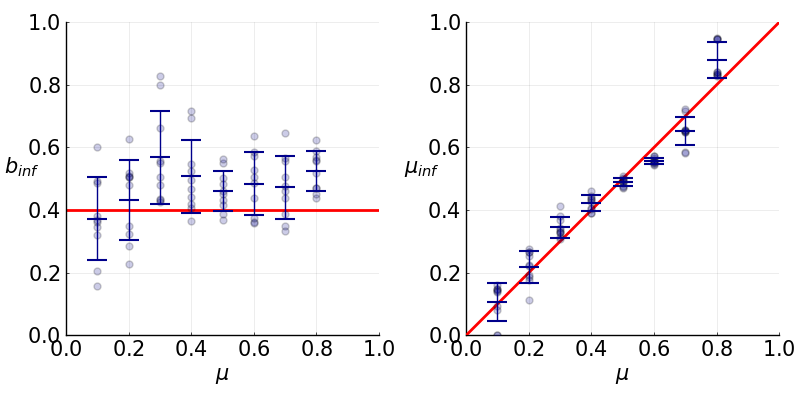

In [93]:
let d = 0.4
    p = plot(layout=(1,2), legend=:none, yguidefontrotation=-90, xlab=L"\mu", size=(800,400), aspect_ratio=1, ticks=0:0.2:1, guidefontsize=15, tickfont=15)

    hline!(p[1], [d], c=:red, lw=2.)
    scatter!(p[1], mus, dfits, ylab=L"b_{inf}", ylims=(0,1), xlims=(0,1), marker = (5, 0.2, :darkblue))
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    plot!(p[2], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[2], mus, mufits, ylab=L"\mu_{inf}", ylims=(0,1), xlims=(0,1), marker = (5, 0.2, :darkblue))
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)

end

In [50]:
# savefig("turnover_plots/inference_new/vary_mu_fit.png")

### Summary

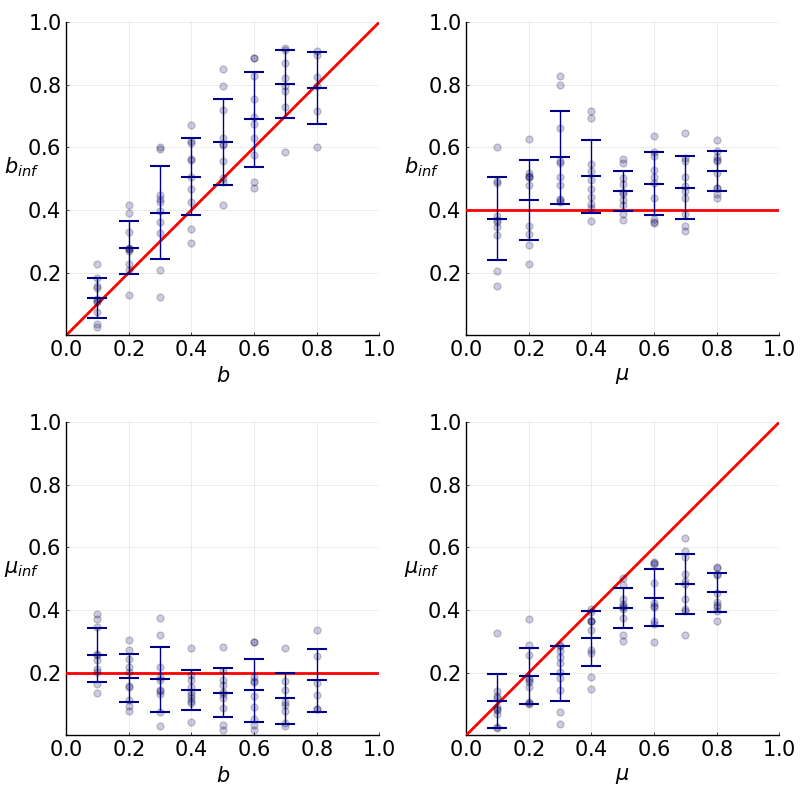

In [108]:
let p = plot(layout=(2,2), legend=:none, yguidefontrotation=-90, size=(800,800),
         aspect_ratio=1, xaxis=((0,1), 0:0.2:1), yaxis=((0,1),0.2:0.2:1), guidefontsize=15, tickfont=15)
    plot!(p[1], xlab=L"b"); plot!(p[3], xlab=L"b"); plot!(p[2], xlab=L"μ"); plot!(p[4], xlab=L"μ")
    
    results = include(projectdir*"/Turnover/inference_results.jl")
    
    method, mu, ds, dfits, mufits = results[1]
    bins = sort!(unique(ds))
    dfits_binned = [ [dfits[findall(isequal(d), ds)]...] for d in bins]
    mufits_binned = [ [mufits[findall(isequal(d), ds)]...] for d in bins]
    
    plot!(p[1], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[1], ds, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[3], [mu], c=:red, lw=2.)
    scatter!(p[3], ds, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[3], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    method, d, mus, dfits, mufits = results[2]
    bins = sort!(unique(mus))
    dfits_binned = [ [dfits[findall(isequal(mu), mus)]...] for mu in bins]
    mufits_binned = [ [mufits[findall(isequal(mu), mus)]...] for mu in bins]
    
    hline!(p[2], [d], c=:red, lw=2.)
    scatter!(p[2], mus, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[2], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    plot!(p[4], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[4], mus, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[4], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)

end

In [110]:
# savefig("turnover_plots/inference_new/inference_solve.pdf")

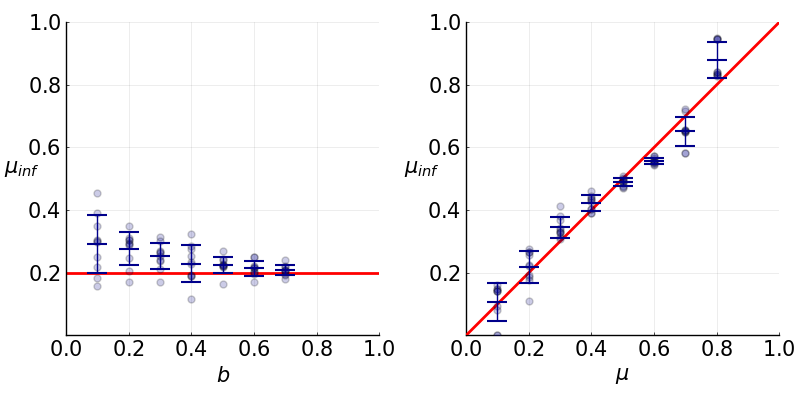

In [111]:
let p = plot(layout=(1,2), legend=:none, yguidefontrotation=-90, size=(800,400),
         aspect_ratio=1, xaxis=((0,1), 0:0.2:1), yaxis=((0,1),0.2:0.2:1), guidefontsize=15, tickfont=15)
    plot!(p[1], xlab=L"b"); plot!(p[2], xlab=L"μ")
    
    results = include(projectdir*"/Turnover/inference_results.jl")
    
    method, mu, ds, dfits, mufits = results[3]
    bins = sort!(unique(ds))
    dfits_binned = [ [dfits[findall(isequal(d), ds)]...] for d in bins]
    mufits_binned = [ [mufits[findall(isequal(d), ds)]...] for d in bins]
    
    hline!(p[1], [mu], c=:red, lw=2.)
    scatter!(p[1], ds, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[1], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
    
    method, d, mus, dfits, mufits = results[4]
    bins = sort!(unique(mus))
    dfits_binned = [ [dfits[findall(isequal(mu), mus)]...] for mu in bins]
    mufits_binned = [ [mufits[findall(isequal(mu), mus)]...] for mu in bins]
    
    plot!(p[2], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[2], mus, mufits, ylab=L"\mu_{inf}", ylims=(0,1), xlims=(0,1), marker = (5, 0.2, :darkblue))
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)

end

In [113]:
# savefig("turnover_plots/inference_new/inference_fit.png")